In [2]:
from dariah_topics import preprocessing as pre
from dariah_topics import visualization as visual
from dariah_topics import evaluation

## Preprocessing

#### Liste mit Dateinamen erzeugen

In [3]:
path_txt = "corpus_txt"
#path_txt = "grenzbote_plain/*/"
#path_txt = "wiki/"

doclist_txt = pre.create_document_list(path_txt)
assert doclist_txt, "No documents found"
doclist_txt[:5]

INFO preprocessing: Creating document list from TXT files ...


['corpus_txt/Doyle_AScandalinBohemia.txt',
 'corpus_txt/Doyle_AStudyinScarlet.txt',
 'corpus_txt/Doyle_TheHoundoftheBaskervilles.txt',
 'corpus_txt/Doyle_TheSignoftheFour.txt',
 'corpus_txt/Howard_GodsoftheNorth.txt']

#####  Liste mit Dokumentenlabels erzeugen - (Funktion wird durch Thorsten's generischere Funktion ersetzt)

In [4]:
doc_labels = list(pre.get_labels(doclist_txt))
doc_labels[:5]

INFO preprocessing: Creating document labels ...


['Doyle_AScandalinBohemia',
 'Doyle_AStudyinScarlet',
 'Doyle_TheHoundoftheBaskervilles',
 'Doyle_TheSignoftheFour',
 'Howard_GodsoftheNorth']

#### Corpus laden

In [5]:
corpus_txt = pre.read_from_txt(doclist_txt)

#### Tokenisieren

In [6]:
doc_tokens = [list(pre.tokenize(txt)) for txt in list(corpus_txt)]

INFO preprocessing: Accessing TXT documents ...


#### Create Dictionaries

In [7]:
id_types = pre.create_dictionary(doc_tokens)
doc_ids = pre.create_dictionary(doc_labels)

#### Sparse BOW Model

In [8]:
sparse_bow = pre.create_mm(doc_labels, doc_tokens, id_types, doc_ids)

In [9]:
sparse_bow[:5]

0
doc_id token_id   
1      16384     1
       16387     2
       5         8
       16391     5
       8         1

## Topic Modeling with Gensim

##### Saving Sparse BOW

In [10]:
pre.save_bow_mm(sparse_bow, "gensim_txt")

#### Import Market Matrix

In [11]:
from gensim.models import LdaModel
from gensim.corpora import MmCorpus

In [12]:
mm = MmCorpus("gensim_txt.mm")

INFO gensim.matutils: initializing corpus reader from gensim_txt.mm
INFO gensim.matutils: accepted corpus with 17 documents, 22232 features, 369906 non-zero entries


In [13]:
doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

##### Remove Features

type2id = {value : key for key, value in id_types.items()}
sparse_bow_collapsed = sparse_bow.groupby(sparse_bow.index.get_level_values('token_id')).sum()

sparse_bow_hapax = sparse_bow_collapsed.loc[sparse_bow_collapsed[0] == 1]
hapax = [type2id[key] for key in sparse_bow_hapax.index.get_level_values('token_id')]

len(hapax)

In [14]:
import os.path
basepath = os.path.abspath('.')

with open(os.path.join(basepath, "tutorial_supplementals", "stopwords", "de.txt"), 'r', encoding = 'utf-8') as f: 
    stopword_list = f.read().split('\n')
    
stopword_list = set(stopword_list)

In [15]:
hapax_from_remove = pre.find_hapax(sparse_bow, id_types)
stopwords_from_remove = pre.find_stopwords(sparse_bow, id_types, mfw=75)

#features_to_be_removed = set(hapax_from_remove + stopwords_from_remove)
features_to_be_removed = stopwords_from_remove

sparse_bow_short = pre.remove_features(sparse_bow, id_types, features_to_be_removed)

INFO preprocessing: Find hapax legomena ...
INFO preprocessing: Finding stopwords ...
INFO preprocessing: Removing features ...


In [16]:
len(features_to_be_removed)

75

In [17]:
pre.save_bow_mm(sparse_bow_short, "gensim_txt")

In [18]:
mm = MmCorpus("gensim_txt.mm")

INFO gensim.matutils: initializing corpus reader from gensim_txt.mm
INFO gensim.matutils: accepted corpus with 17 documents, 22232 features, 192053 non-zero entries


#### Convert sparse_bow to list of (doc, tokens) tuples (like doc2bow)

In [19]:
doc2bow_list = []

for doc in sparse_bow_short.index.groupby(sparse_bow_short.index.get_level_values('doc_id')):
    temp = [(token, count) for token, count in zip(sparse_bow_short.loc[doc].index, sparse_bow_short.loc[doc][0])]
    doc2bow_list.append(temp)

In [20]:
len(doc2bow_list)

17

In [21]:
#model = LdaModel(corpus=mm, id2word=type2id, num_topics=60, alpha = "symmetric", passes = 10) #import momentan in visual 
# -> da ich mir noch nicht sicher bin, welche Funktionen in das tm_gensim.py sollen
model = LdaModel(corpus=mm, id2word=type2id, num_topics=20, passes = 10, iterations = 20)

INFO gensim.models.ldamodel: using symmetric alpha at 0.05
INFO gensim.models.ldamodel: using symmetric eta at 4.49781855799937e-05
INFO gensim.models.ldamodel: using serial LDA version on this node
INFO gensim.models.ldamodel: running online LDA training, 20 topics, 10 passes over the supplied corpus of 17 documents, updating model once every 17 documents, evaluating perplexity every 17 documents, iterating 20x with a convergence threshold of 0.001000
INFO gensim.models.ldamodel: -14.378 per-word bound, 21293.5 perplexity estimate based on a held-out corpus of 17 documents with 192053 words
INFO gensim.models.ldamodel: PROGRESS: pass 0, at document #17/17
INFO gensim.models.ldamodel: topic #7 (0.050): 0.003*"argument" + 0.003*"lightish" + 0.003*"stolid" + 0.003*"bristled" + 0.003*"halloa" + 0.003*"gradings" + 0.003*"lightly" + 0.002*"commander" + 0.002*"vast-enough" + 0.002*"antiquity"
INFO gensim.models.ldamodel: topic #9 (0.050): 0.004*"vast-enough" + 0.003*"bristled" + 0.003*"light

In [22]:
model.get_document_topics(doc2bow_list[1])

[(0, 0.055873395992774702),
 (1, 0.044800377975782915),
 (2, 0.021977716143184885),
 (4, 0.032973434512450606),
 (5, 0.032222967454788032),
 (6, 0.29064478027061624),
 (9, 0.066286775823352878),
 (14, 0.073883870840484478),
 (15, 0.21548431802799242),
 (18, 0.11099619950188283),
 (19, 0.053536600533612172)]

In [23]:
#Anzeige der keywords für topic n
n = 1
topic_nr_x = model.get_topic_terms(n)

topicTerms = [type2id[i[0]] for i in topic_nr_x]
topicTerms

['platforms',
 'query',
 'anthropoid',
 'chum',
 'stolid',
 'really',
 'tradesmen',
 'fumble',
 'gradings',
 'smother']

In [24]:
#Topic probabilities - zum Testen der Funktion
topics = model.show_topics(num_topics = model.num_topics, formatted=False)

num_topics = model.num_topics
topics_df = pre.pd.DataFrame(index = range(num_topics), columns= range(10))

for topic in topics:
    idx = topic[0]
    temp = topic[1]
    topics_df.loc[idx] = temp
        
topics_df

,0,1,2,3,4,5,6,7,8,9
0,"(halloa, 0.00716161971281)","(bristled, 0.00571245443054)","(lonesome, 0.00512472893873)","(antiquity, 0.00502035159775)","(khosatral, 0.00498597154715)","(turned, 0.0047661846979)","(limited, 0.0046067487038)","(draggly, 0.0043915386025)","(sicken, 0.00414012982306)","(spared, 0.00401165130928)"
1,"(platforms, 0.00888665965021)","(query, 0.00634314775966)","(anthropoid, 0.00546447960219)","(chum, 0.00532520021467)","(stolid, 0.00526269035145)","(really, 0.00513682664394)","(tradesmen, 0.00508045472031)","(fumble, 0.00507725305647)","(gradings, 0.00503717588128)","(smother, 0.0047712199428)"
2,"(hard, 0.00726266261035)","(beg, 0.00701270013027)","(gathered, 0.00613989873627)","(gray-beards, 0.00421085325873)","(sandstone, 0.00416858365147)","(turned, 0.00377871860299)","(contagious, 0.00309790507719)","(lightish, 0.00293157883845)","(well-beloved, 0.00290141146518)","(barks, 0.00289361247745)"
3,"(slender, 0.000717739333607)","(lightish, 0.000434043523391)","(halloa, 0.000426811357913)","(commander, 0.000422201650515)","(sacrifice, 0.00040892052468)","(rejection, 0.000402912458865)","(unmanned, 0.00040169221079)","(congruity, 0.00039721789447)","(lonesome, 0.000395057389958)","(bristled, 0.000388204113456)"
4,"(six-mile, 0.00897247485674)","(afar, 0.00666987189238)","(tense, 0.00443027842894)","(vast-enough, 0.00394278222092)","(loading, 0.00378515784848)","(gray-beards, 0.0036703868636)","(resistance, 0.00352989281229)","(letzten, 0.00339312300033)","(stolid, 0.00327242095376)","(night-times, 0.00316448109284)"
5,"(vast-enough, 0.00590339090413)","(tense, 0.00347532030258)","(cynical, 0.00344660172915)","(rodger, 0.00335198098478)","(lightish, 0.00331909589206)","(gray-beards, 0.00326528293132)","(rafters, 0.00300671705797)","(opposition, 0.00295219064446)","(valueless, 0.00293599935716)","(whirl, 0.00264578779817)"
6,"(nasty, 0.00371939191261)","(gray-beards, 0.00357150858524)","(commander, 0.00350569085354)","(wrote, 0.00345119158167)","(cynical, 0.00335816150495)","(beast's, 0.00324210836771)","(lightish, 0.00307610281796)","(unmanned, 0.00299791954519)","(half-ruined, 0.002895289367)","(well-beloved, 0.00288392485085)"
7,"(argument, 0.000281760074929)","(lightish, 0.000256572827199)","(stolid, 0.000248820316373)","(halloa, 0.00024763857207)","(bristled, 0.000241841556234)","(gradings, 0.000237156549197)","(lightly, 0.00022803270767)","(antiquity, 0.000224158793871)","(commander, 0.000223133920567)","(vast-enough, 0.000220549006771)"
8,"(argument, 0.000457392352969)","(commander, 0.000433691565041)","(lightly, 0.0004121470393)","(stolid, 0.000403158393883)","(lonesome, 0.000398503075896)","(waged, 0.000394180544447)","(lightish, 0.00039245315965)","(nasty, 0.000384117554422)","(bristled, 0.000383096463505)","(vast-enough, 0.000380146027051)"
9,"(slender, 0.0117254359618)","(six-mile, 0.00546099574407)","(sacrifice, 0.00528032125244)","(halloa, 0.0051860960478)","(congruity, 0.00515752585155)","(tense, 0.00455163389008)","(screaming, 0.00431575094465)","(rejection, 0.00428752799547)","(lightish, 0.0041835658056)","(rafters, 0.00374217782815)"


In [25]:
topics_df = pre.gensim2dataframe(model)
topics_df

,0,1,2,3,4,5,6,7,8,9
0,"(halloa, 0.00716161971281)","(bristled, 0.00571245443054)","(lonesome, 0.00512472893873)","(antiquity, 0.00502035159775)","(khosatral, 0.00498597154715)","(turned, 0.0047661846979)","(limited, 0.0046067487038)","(draggly, 0.0043915386025)","(sicken, 0.00414012982306)","(spared, 0.00401165130928)"
1,"(platforms, 0.00888665965021)","(query, 0.00634314775966)","(anthropoid, 0.00546447960219)","(chum, 0.00532520021467)","(stolid, 0.00526269035145)","(really, 0.00513682664394)","(tradesmen, 0.00508045472031)","(fumble, 0.00507725305647)","(gradings, 0.00503717588128)","(smother, 0.0047712199428)"
2,"(hard, 0.00726266261035)","(beg, 0.00701270013027)","(gathered, 0.00613989873627)","(gray-beards, 0.00421085325873)","(sandstone, 0.00416858365147)","(turned, 0.00377871860299)","(contagious, 0.00309790507719)","(lightish, 0.00293157883845)","(well-beloved, 0.00290141146518)","(barks, 0.00289361247745)"
3,"(slender, 0.000717739333607)","(lightish, 0.000434043523391)","(halloa, 0.000426811357913)","(commander, 0.000422201650515)","(sacrifice, 0.00040892052468)","(rejection, 0.000402912458865)","(unmanned, 0.00040169221079)","(congruity, 0.00039721789447)","(lonesome, 0.000395057389958)","(bristled, 0.000388204113456)"
4,"(six-mile, 0.00897247485674)","(afar, 0.00666987189238)","(tense, 0.00443027842894)","(vast-enough, 0.00394278222092)","(loading, 0.00378515784848)","(gray-beards, 0.0036703868636)","(resistance, 0.00352989281229)","(letzten, 0.00339312300033)","(stolid, 0.00327242095376)","(night-times, 0.00316448109284)"
5,"(vast-enough, 0.00590339090413)","(tense, 0.00347532030258)","(cynical, 0.00344660172915)","(rodger, 0.00335198098478)","(lightish, 0.00331909589206)","(gray-beards, 0.00326528293132)","(rafters, 0.00300671705797)","(opposition, 0.00295219064446)","(valueless, 0.00293599935716)","(whirl, 0.00264578779817)"
6,"(nasty, 0.00371939191261)","(gray-beards, 0.00357150858524)","(commander, 0.00350569085354)","(wrote, 0.00345119158167)","(cynical, 0.00335816150495)","(beast's, 0.00324210836771)","(lightish, 0.00307610281796)","(unmanned, 0.00299791954519)","(half-ruined, 0.002895289367)","(well-beloved, 0.00288392485085)"
7,"(argument, 0.000281760074929)","(lightish, 0.000256572827199)","(stolid, 0.000248820316373)","(halloa, 0.00024763857207)","(bristled, 0.000241841556234)","(gradings, 0.000237156549197)","(lightly, 0.00022803270767)","(antiquity, 0.000224158793871)","(commander, 0.000223133920567)","(vast-enough, 0.000220549006771)"
8,"(argument, 0.000457392352969)","(commander, 0.000433691565041)","(lightly, 0.0004121470393)","(stolid, 0.000403158393883)","(lonesome, 0.000398503075896)","(waged, 0.000394180544447)","(lightish, 0.00039245315965)","(nasty, 0.000384117554422)","(bristled, 0.000383096463505)","(vast-enough, 0.000380146027051)"
9,"(slender, 0.0117254359618)","(six-mile, 0.00546099574407)","(sacrifice, 0.00528032125244)","(halloa, 0.0051860960478)","(congruity, 0.00515752585155)","(tense, 0.00455163389008)","(screaming, 0.00431575094465)","(rejection, 0.00428752799547)","(lightish, 0.0041835658056)","(rafters, 0.00374217782815)"


In [26]:
doc_topic = topics_df.T
doc_topic

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,"(halloa, 0.00716161971281)","(platforms, 0.00888665965021)","(hard, 0.00726266261035)","(slender, 0.000717739333607)","(six-mile, 0.00897247485674)","(vast-enough, 0.00590339090413)","(nasty, 0.00371939191261)","(argument, 0.000281760074929)","(argument, 0.000457392352969)","(slender, 0.0117254359618)","(waged, 0.000269709439137)","(guddee, 0.00081968830949)","(lightish, 0.000286058422173)","(waged, 0.000426590280446)","(mahouts, 0.00573826391415)","(lightly, 0.00475631972476)","(stolid, 0.00043650165615)","(halloa, 0.000551991342755)","(gray-beards, 0.00959791288658)","(tokay, 0.0062084700607)"
1,"(bristled, 0.00571245443054)","(query, 0.00634314775966)","(beg, 0.00701270013027)","(lightish, 0.000434043523391)","(afar, 0.00666987189238)","(tense, 0.00347532030258)","(gray-beards, 0.00357150858524)","(lightish, 0.000256572827199)","(commander, 0.000433691565041)","(six-mile, 0.00546099574407)","(handcuffs, 0.000262925570865)","(t-happen, 0.000798815607312)","(gradings, 0.000248808196581)","(bristled, 0.000421549077689)","(platforms, 0.00526402824759)","(knowest, 0.00473766488703)","(nasty, 0.00041478490118)","(lightly, 0.000503392992729)","(well-beloved, 0.00595402873829)","(perplexing, 0.00616954843535)"
2,"(lonesome, 0.00512472893873)","(anthropoid, 0.00546447960219)","(gathered, 0.00613989873627)","(halloa, 0.000426811357913)","(tense, 0.00443027842894)","(cynical, 0.00344660172915)","(commander, 0.00350569085354)","(stolid, 0.000248820316373)","(lightly, 0.0004121470393)","(sacrifice, 0.00528032125244)","(bristled, 0.000230745283874)","(advanced, 0.000789071926099)","(cynical, 0.000240483135874)","(gradings, 0.00039901061162)","(lightly, 0.00390231960353)","(incipiency, 0.00415723165296)","(long-wished, 0.00038869194818)","(bristled, 0.000464641567629)","(nasty, 0.00552633648687)","(six-mile, 0.00432088892298)"
3,"(antiquity, 0.00502035159775)","(chum, 0.00532520021467)","(gray-beards, 0.00421085325873)","(commander, 0.000422201650515)","(vast-enough, 0.00394278222092)","(rodger, 0.00335198098478)","(wrote, 0.00345119158167)","(halloa, 0.00024763857207)","(stolid, 0.000403158393883)","(halloa, 0.0051860960478)","(nasty, 0.000226727981679)","(fortunes, 0.000782417690546)","(waged, 0.000238937573135)","(keswick, 0.000390429428468)","(chum, 0.0038577167677)","(lightish, 0.00393878900611)","(rafters, 0.000386758131272)","(lightish, 0.000441664278535)","(downright, 0.00470237363276)","(seek, 0.00419248739075)"
4,"(khosatral, 0.00498597154715)","(stolid, 0.00526269035145)","(sandstone, 0.00416858365147)","(sacrifice, 0.00040892052468)","(loading, 0.00378515784848)","(lightish, 0.00331909589206)","(cynical, 0.00335816150495)","(bristled, 0.000241841556234)","(lonesome, 0.000398503075896)","(congruity, 0.00515752585155)","(commander, 0.000226270970134)","(either, 0.000780434795412)","(lightly, 0.000238463691128)","(rôle, 0.000368047207922)","(keswick, 0.00353684260354)","(keswick, 0.00390619533079)","(keswick, 0.000380392049134)","(micefield, 0.000434848573995)","(sledging, 0.00462009844772)","(toppled, 0.00416019941713)"
5,"(turned, 0.0047661846979)","(really, 0.00513682664394)","(turned, 0.00377871860299)","(rejection, 0.000402912458865)","(gray-beards, 0.0036703868636)","(gray-beards, 0.00326528293132)","(beast's, 0.00324210836771)","(gradings, 0.000237156549197)","(waged, 0.000394180544447)","(tense, 0.00455163389008)","(antiquity, 0.000225106339166)","(credibilities, 0.000777719966008)","(vast-enough, 0.000237140132774)","(stolid, 0.000365039551895)","(fumble, 0.00350376247349)","(waged, 0.0035776312554)","(lightish, 0.000376829948168)","(donations, 0.000427709462134)","(transcendent, 0.00457680412483)","(screaming, 0.00408442841323)"
6,"(limited, 0.0046067487038)","(tradesmen, 0.00508045472031)","(contagious, 0.00309790507719)","(unmanned, 0.00040169221079)","(resistance, 0.00352989281229)","(rafters, 0.00300671705797)","(lightish, 0.00307610281796)","(lightly, 0.00022803

## Visualisierung 

In [27]:
'''lda_model = 'out_easy/corpus.lda'
corpus = 'out_easy/corpus.mm'
dictionary = 'out_easy/corpus.dict'
doc_labels = 'out_easy/corpus_doclabels.txt'
interactive  = False

vis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)'''

"lda_model = 'out_easy/corpus.lda'\ncorpus = 'out_easy/corpus.mm'\ndictionary = 'out_easy/corpus.dict'\ndoc_labels = 'out_easy/corpus_doclabels.txt'\ninteractive  = False\n\nvis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)"

##### Create a document-topic matrix (that is a pandas data frame actually)

In [28]:
doc_topic = visual.create_doc_topic(mm, model, doc_labels)

##### Visualize document-topic matrix

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

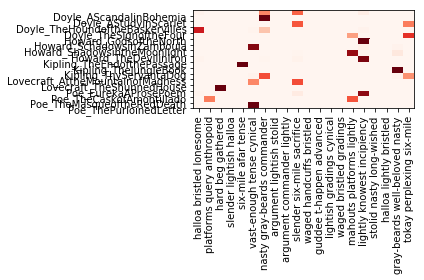

In [29]:
%matplotlib inline
visual.doc_topic_heatmap(doc_topic)

##### Visualize topic distribution in a single document

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

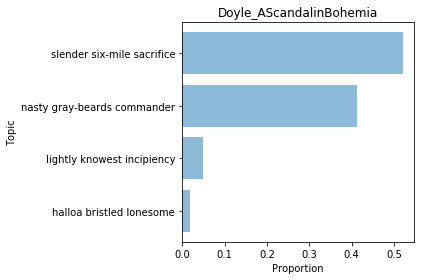

In [30]:
visual.plot_doc_topics(doc_topic, 0)

![success](http://cdn2.hubspot.net/hub/128506/file-446943132-jpg/images/computer_woman_success.jpg)